<a href="https://colab.research.google.com/github/cyyoon0311/Machine-learning/blob/main/Homework3_2021111939_%EC%9C%A4%EC%B0%AC%EC%98%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training set mean: [4.63438257e+00 4.26150121e+00 7.39951574e+00 9.06476998e+01
 1.88450363e+01 3.96949153e+00 2.37288136e-02]
Training set std: [2.31417977 1.22499975 2.30016312 5.55846111 5.76846279 1.75192429
 0.32359758]
Sample transformed training data: [[  1.          14.33527119  -0.21347042  -0.34531318  -0.14054567
   -0.06975801  -0.18731716  -0.25383654  -0.71998774  -0.71998774
   -0.18731716   0.          -0.09889364  -0.27412847   0.60285628
  -12.94381635  -2.36545451  -1.75206859  -0.07332816]
 [  1.          -0.06975801  -0.21347042  -0.34531318  -0.14054567
   -0.06975801  -0.18731716  -0.25383654   1.38891253  -0.71998774
   -0.18731716   0.          -0.09889364   1.45434572   1.41918298
    0.2612774    1.15368061  -1.23834776  -0.07332816]
 [  1.          -0.06975801  -0.21347042  -0.34531318  -0.14054567
   -0.06975801  -0.18731716  -0.25383654   1.38891253  -0.71998774
   -0.18731716   0.          -0.09889364   1.45434572   0.60285628
    0.44118331   1.37904394 

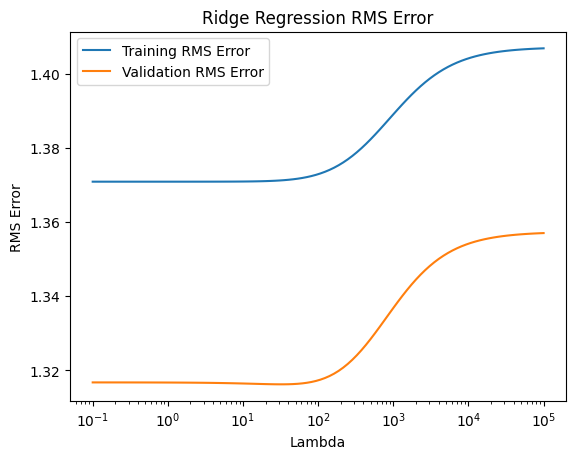

Sample transformed training data with Sinusoidal embedding: [[ 1.00000000e+00  5.00000000e-01  8.66025404e-01 -2.74128473e-01
   6.02856279e-01 -1.29438164e+01 -2.36545451e+00 -1.75206859e+00
  -7.33281552e-02]
 [ 1.00000000e+00 -8.66025404e-01 -5.00000000e-01  1.45434572e+00
   1.41918298e+00  2.61277396e-01  1.15368061e+00 -1.23834776e+00
  -7.33281552e-02]
 [ 1.00000000e+00 -8.66025404e-01 -5.00000000e-01  1.45434572e+00
   6.02856279e-01  4.41183305e-01  1.37904394e+00 -4.96306564e-01
  -7.33281552e-02]
 [ 1.00000000e+00 -1.00000000e+00 -1.83697020e-16  5.90108621e-01
   6.02856279e-01  4.53903045e-02  4.25583690e-01 -1.01002739e+00
  -7.33281552e-02]
 [ 1.00000000e+00 -8.66025404e-01 -5.00000000e-01  1.57990074e-01
  -2.13470420e-01  7.47023351e-01  2.52227280e-01 -7.24626932e-01
  -7.33281552e-02]]


In [2]:
import numpy as np
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

# 데이터 로드
with open('wildfire_data.json', 'r') as f:
    data = json.load(f)

U = np.array(data['U'])  # n x d 행렬 (x, y, 월, FFMC, 온도, 바람, 비)
v = np.array(data['v'])  # n 벡터 (화재 영역 크기)

# 'U'에서 'data' 키를 사용해 실제 데이터를 추출
x = np.array(data["U"]["data"])  # 특성 데이터
y = np.array(data["v"]["data"])  # 타겟 데이터

# (a) 데이터 분할
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)


# 표준화
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)

# 평균과 표준편차 출력
print("Training set mean:", scaler.mean_)
print("Training set std:", scaler.scale_)

# (b) One-Hot Encoding for '월'
ohe = OneHotEncoder(sparse_output=False, categories=[np.arange(1, 13)])
month_train = ohe.fit_transform(x_train[:, 2].reshape(-1, 1))
month_val = ohe.transform(x_val[:, 2].reshape(-1, 1))

# 표준화
month_scaler = StandardScaler()
month_train_scaled = month_scaler.fit_transform(month_train)
month_val_scaled = month_scaler.transform(month_val)

# 새로운 데이터 행렬 구성
x_train_final = np.hstack([np.ones((x_train.shape[0], 1)), month_train_scaled, x_train_scaled[:, [0, 1, 3, 4, 5, 6]]])
x_val_final = np.hstack([np.ones((x_val.shape[0], 1)), month_val_scaled, x_val_scaled[:, [0, 1, 3, 4, 5, 6]]])

print("Sample transformed training data:", x_train_final[:5])

# (c) 릿지 회귀 및 RMS 에러 계산
lambdas = np.logspace(-1, 5, 100)
rms_train, rms_val = [], []

for lmbda in lambdas:
    ridge = Ridge(alpha=lmbda)
    ridge.fit(x_train_final, y_train)

    train_pred = ridge.predict(x_train_final)
    val_pred = ridge.predict(x_val_final)

    rms_train.append(np.sqrt(np.mean((y_train - train_pred) ** 2)))
    rms_val.append(np.sqrt(np.mean((y_val - val_pred) ** 2)))

# 최적의 lambda 찾기
best_lambda = lambdas[np.argmin(rms_val)]
print("Best lambda:", best_lambda)
print("Minimum RMS error:", min(rms_val))

# RMS 에러 플롯
g = plt.figure()
plt.plot(lambdas, rms_train, label='Training RMS Error')
plt.plot(lambdas, rms_val, label='Validation RMS Error')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('RMS Error')
plt.legend()
plt.title('Ridge Regression RMS Error')
plt.show()

# (d) Sinusoidal Embedding 적용
month_train_sin_cos = np.hstack([
    np.sin(2 * np.pi * x_train[:, 2].reshape(-1, 1) / 12),
    np.cos(2 * np.pi * x_train[:, 2].reshape(-1, 1) / 12)
])
month_val_sin_cos = np.hstack([
    np.sin(2 * np.pi * x_val[:, 2].reshape(-1, 1) / 12),
    np.cos(2 * np.pi * x_val[:, 2].reshape(-1, 1) / 12)
])

x_train_sinusoidal = np.hstack([np.ones((x_train.shape[0], 1)), month_train_sin_cos, x_train_scaled[:, [0, 1, 3, 4, 5, 6]]])
x_val_sinusoidal = np.hstack([np.ones((x_val.shape[0], 1)), month_val_sin_cos, x_val_scaled[:, [0, 1, 3, 4, 5, 6]]])

print("Sample transformed training data with Sinusoidal embedding:", x_train_sinusoidal[:5])

# (e) Sinusoidal Embedding이 적절한 이유
# '월' 데이터는 12개월 주기로 반복되는 특성이 있다. sin, cos 변환이 이 주기성을 효과적으로 반영할 수 있고,
# One-Hot Encoding보다 1월과 12월이 가깝다는 정보를 반영하여 연속적인 관계를 유지할 수 있다.
# 또한, 12개의 feature 대신 2개의 feature만 사용하므로 차원의 저주(Dimensionality Curse)를 방지할 수 있다.